In [2]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
import joblib

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
import numpy as np

from statistics import mode


#read the csv file
df = pd.read_csv('data/stat_acc_V3_new.csv', sep=';')

### 1 - Répartition des données

In [3]:
# Sélection des 5 attributs qui nous intéresses pour l'apprentissage
#df = df[['age', 'latitude', 'longitude','descr_athmo','descr_grav']]
df = df[['age', 'latitude', 'longitude', 'descr_grav','descr_athmo','descr_cat_veh','descr_lum','descr_etat_surf']]

# initialisation des variables X et Y contenant la data et la target de notre base de donnée
X = df.drop(['descr_grav'], axis=1)
Y = df['descr_grav']

# Séparation de la base de donnée en base de validation et d'entrainement
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Séparation de la base d'entrainement en base d'apprentissage et de validation
#X_app, X_test, y_app, y_test = train_test_split(X_train, y_train, test_size=0.16, random_state=42)

Nous nous limitons donc ici à 5 attributs pour la base de données : ['age', 'latitude', 'longitude', 'descr_grav','descr_athmo','descr_cat_veh','descr_lum','descr_etat_surf'].
Notre répartition est la suivante : base d'entraînement 80% et base de validation 20% 
Dans la suite nous allons donc diviser la base d'entraînement en base d'apprentissage et de test selon la répartition holdout et leave one out.

Dans la suite X et Y vont correspondre à X_train et y_train.

In [4]:
X = X_train
Y = y_train

In [5]:
X.head()

,age,latitude,longitude,descr_athmo,descr_cat_veh,descr_lum,descr_etat_surf
37295,51,43.8833,-0.500000,1,7,3,1
71390,56,42.6809,9.302510,1,7,1,1
51318,84,43.1000,5.883330,1,7,1,1
22545,50,43.6000,1.433330,1,15,1,1
36056,71,44.5000,0.966667,1,7,1,1


In [6]:
Y.head()

37295    1
71390    1
51318    3
22545    1
36056    3
Name: descr_grav, dtype: int64

#### 1.1 - Holdout Répartition

In [7]:
def holdout_repartition(X, Y, list, n):

    # Répétition 5 fois de holdout split
    for i in range(n):
        # Division des données en ensembles d'apprentissage et de tests
        X_app, X_test, y_app, y_test = train_test_split(X, Y, test_size=0.16, random_state=i)
        
        # Ajouter les ensembles d'apprentissage et de test à la liste
        list.append((X_app, X_test, y_app, y_test))
    

In [8]:
# Initialisation de la liste
holdout_app_test_sets = []

# Nombre de répétitions de holdout split
n = 5

# Ececution de la fonction holdout_repartition
holdout_repartition(X, Y, holdout_app_test_sets, n)

#### 1.2 - Leave One out Répartition

In [9]:
def leaveoneout_repartition(X, Y, list):
    
    # Création de l'objet leave one out
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(leaveoneout_sample):     
        # Ajouter les ensembles d'apprentissage et de test et d'apprentissage à la liste
        list.append((X.iloc[train_index], X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]))

In [10]:
# Récupération de 10% des données de chaque niveau de gravité
gravite_1 = df[df['descr_grav'] == 1].sample(frac=0.1, random_state=42)
gravite_2 = df[df['descr_grav'] == 2].sample(frac=0.1, random_state=42)
gravite_3 = df[df['descr_grav'] == 3].sample(frac=0.1, random_state=42)
gravite_4 = df[df['descr_grav'] == 4].sample(frac=0.1, random_state=42)

# Concaténation des échantillons sélectionnés
leaveoneout_sample = pd.concat([gravite_1, gravite_2, gravite_3, gravite_4])

#initialisation des variables X et Y du sample leaveoneout 
X_leaveoneout = df.drop(['descr_grav'], axis=1)
Y_leaveoneout = df['descr_grav']

# Initialisation de la liste
leaveoneout_app_test_sets = []

# Execution de leave one out
leaveoneout_repartition(X_leaveoneout, Y_leaveoneout, leaveoneout_app_test_sets)

In [11]:
# Liste pour stocker les valeurs d'accuracy
accuracy_list = [] 

# Boucle faisant la prédiction et l'évaluation pour chaque répartition holdout
for i, (X_app, X_test, y_app, y_test) in enumerate(leaveoneout_app_test_sets): 
   
   # Création du modèle KNN
   knn = KNeighborsClassifier(n_neighbors=5)

   # Apprentissage du modèle KNN
   knn.fit(X_app, y_app)

   # Prédiction des données de test
   y_pred = knn.predict(X_test)

   # Evaluation de la prédiction
   accuracy = accuracy_score(y_test, y_pred)
   
   # Ajout de l'accuracy à la liste
   accuracy_list.append(accuracy) 

In [12]:
# Calcul de la moyenne des accuracy
mean_accuracy = np.mean(accuracy_list)

print("Moyenne de l'accuracy :", mean_accuracy)

# Récupération de l'indice correspondant à l'accuracy la plus grande dans la liste holdout_app_test_sets
n_leaveoneout = np.argmax(accuracy_list)

print("Indice de le précision maximum dans la liste :", n_leaveoneout)

Moyenne de l'accuracy : 0.44989136338946223
Indice de le précision maximum dans la liste : 0


### 2 - Classification avec KNN

#### 2.1 - "From scratch"

In [13]:
def distHamming(p1, p2):
    return np.sum(p1 != p2,axis=1)

def distManhattan(p1, p2):
    return np.sum(np.abs(p1 - p2),axis=1)

def distMinkowski(x, y, p):
    return np.power(np.sum(np.power(np.abs(x - y), p)), 1/p)

def predict_knn(X_train, y_train, X_test, k):
    neighbors = []

    for x in X_test.values:
        #distances = distManhattan(x, X_train)
        distances = distHamming(x, X_train)
        #distances = distMinkowski(x, X_train,2)
        y_sorted = [y for _, y in sorted(zip(distances, y_train))]
        neighbors.append(list(y_sorted[:k]))
    return [mode(n) for n in neighbors]

df = pd.read_csv("data/stat_acc_V3_new.csv", sep=";")
#data = df.groupby("descr_grav").apply(lambda x: x.sample(frac=0.1))
selected_columns = ['age', 'latitude', 'longitude', 'descr_grav','descr_athmo','descr_cat_veh','descr_lum','descr_etat_surf']
df_selected = df[selected_columns].copy()

df_selected.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df[['age', 'latitude', 'longitude', 'descr_athmo','descr_cat_veh','descr_lum','descr_etat_surf']],
                                                    df['descr_grav'], test_size=0.2, random_state=42)
k = 6
y_pred = predict_knn(X_train, y_train, X_test, k)

# TEST EVALUATION 
print(y_pred)
accuracy_score(y_test, y_pred)


# from sklearn.metrics import silhouette_score
# silhouette_avg = silhouette_score(y_test, y_pred)
# print("Silhouette Coefficient :", silhouette_avg)

# from sklearn.metrics import calinski_harabasz_score
# ch_score = calinski_harabasz_score(y_test, y_pred)
# print("Calinski-Harabasz Index :", ch_score)

# from sklearn.metrics import davies_bouldin_score
# db_score = davies_bouldin_score(y_test, y_pred)
# print("Davies-Bouldin Index :", db_score)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 3, 1, 1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 4, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 

0.5314367191743617

#### 2.2 - Bibliothèque scikit-learn

##### 2.2.1 - Distance Hamming

In [33]:
# Liste pour stocker les valeurs d'accuracy
accuracy_list = []

# Boucle faisant varier k de 1 à 10
for k in range(1, 11):
    # Liste pour stocker les valeurs d'accuracy pour chaque k
    k_accuracy_list = []
    
    # Boucle faisant la prédiction et l'évaluation pour chaque répartition holdout
    for i in range(5):
        # Accès aux bases provenant de la répartition holdout
        X_app, X_test, y_app, y_test = holdout_app_test_sets[i]

        # Création du modèle KNN
        knn = KNeighborsClassifier(n_neighbors=k, metric='hamming')

        # Convertir les données catégorielles en encodage one-hot
        X_app = pd.get_dummies(X_app)

        # Apprentissage du modèle KNN
        knn.fit(X_app, y_app)

        # Prédiction des données de test
        y_pred = knn.predict(X_test)

        # Evaluation de la prédiction
        accuracy = accuracy_score(y_test, y_pred)

        # Ajout de l'accuracy à la liste pour chaque k
        k_accuracy_list.append(accuracy)
    
    # Ajout de la liste des accuracy pour chaque k à la liste principale
    accuracy_list.append(k_accuracy_list)

# Calcul de la moyenne des accuracy pour chaque k
mean_accuracy_list = [np.mean(acc) for acc in accuracy_list]

# Affichage des moyennes des accuracy pour chaque k
for k, mean_acc in enumerate(mean_accuracy_list):
    print("Moyenne de l'accuracy pour k =", k+1, ":", mean_acc)

# Récupération de l'indice correspondant à la moyenne de l'accuracy la plus grande dans la liste
n = np.argmax(mean_accuracy_list)

print("Indice de la moyenne de l'accuracy la plus grande :", n+1)


Moyenne de l'accuracy pour k = 1 : 0.4526628474432421
Moyenne de l'accuracy pour k = 2 : 0.46970082749840864
Moyenne de l'accuracy pour k = 3 : 0.4824315722469765
Moyenne de l'accuracy pour k = 4 : 0.4967324421812009
Moyenne de l'accuracy pour k = 5 : 0.4979206450244006
Moyenne de l'accuracy pour k = 6 : 0.5052196053469128
Moyenne de l'accuracy pour k = 7 : 0.5059834500318268
Moyenne de l'accuracy pour k = 8 : 0.5104179927859114
Moyenne de l'accuracy pour k = 9 : 0.5132611924464248
Moyenne de l'accuracy pour k = 10 : 0.5131338849989391
Indice de la moyenne de l'accuracy la plus grande : 9


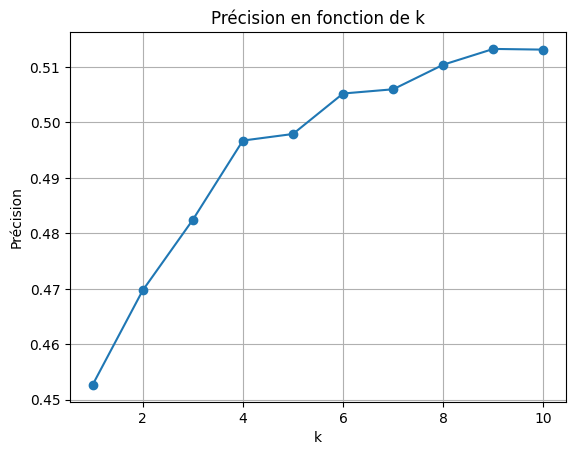

In [50]:
# tracage du graphique
import matplotlib.pyplot as plt
k_values = range(1, 11)
plt.plot(k_values, mean_accuracy_list, marker='o')
plt.xlabel('k')
plt.ylabel('Précision')
plt.title('Précision en fonction de k')
plt.grid(True)
plt.show()

##### 2.2.2 - Distance Manhattan

In [47]:
# Liste pour stocker les valeurs d'accuracy
accuracy_list = []

# Boucle faisant varier k de 1 à 100
for k in range(1, 101):
    # Liste pour stocker les valeurs d'accuracy pour chaque k
    k_accuracy_list = []
    
    # Boucle faisant la prédiction et l'évaluation pour chaque répartition holdout
    for i in range(5):
        # Accès aux bases provenant de la répartition holdout
        X_app, X_test, y_app, y_test = holdout_app_test_sets[i]

        # Création du modèle KNN
        knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')

        # Apprentissage du modèle KNN
        knn.fit(X_app, y_app)

        # Prédiction des données de test
        y_pred = knn.predict(X_test)

        # Evaluation de la prédiction
        accuracy = accuracy_score(y_test, y_pred)

        # Ajout de l'accuracy à la liste pour chaque k
        k_accuracy_list.append(accuracy)
    
    # Ajout de la liste des accuracy pour chaque k à la liste principale
    accuracy_list.append(k_accuracy_list)

# Calcul de la moyenne des accuracy pour chaque k
mean_accuracy_list = [np.mean(acc) for acc in accuracy_list]

# Affichage des moyennes des accuracy pour chaque k
for k, mean_acc in enumerate(mean_accuracy_list):
    print("Moyenne de l'accuracy pour k =", k+1, ":", mean_acc)

# Récupération de l'indice correspondant à la moyenne de l'accuracy la plus grande dans la liste
n = np.argmax(mean_accuracy_list)

print("Indice de la moyenne de l'accuracy la plus grande :", n+1)

Moyenne de l'accuracy pour k = 1 : 0.4718650541056652
Moyenne de l'accuracy pour k = 2 : 0.49102482495225974
Moyenne de l'accuracy pour k = 3 : 0.5080840229153405
Moyenne de l'accuracy pour k = 4 : 0.5252493104179928
Moyenne de l'accuracy pour k = 5 : 0.5287927010396775
Moyenne de l'accuracy pour k = 6 : 0.5353490345851899
Moyenne de l'accuracy pour k = 7 : 0.5394440908126459
Moyenne de l'accuracy pour k = 8 : 0.5451729259495014
Moyenne de l'accuracy pour k = 9 : 0.5446636961595586
Moyenne de l'accuracy pour k = 10 : 0.5470613197538722
Moyenne de l'accuracy pour k = 11 : 0.5480373435179292
Moyenne de l'accuracy pour k = 12 : 0.5507532357309569
Moyenne de l'accuracy pour k = 13 : 0.5526628474432421
Moyenne de l'accuracy pour k = 14 : 0.5547634203267557
Moyenne de l'accuracy pour k = 15 : 0.5543814979842987
Moyenne de l'accuracy pour k = 16 : 0.5566305962232124
Moyenne de l'accuracy pour k = 17 : 0.5554848291958413
Moyenne de l'accuracy pour k = 18 : 0.5576490558030979
Moyenne de l'accur

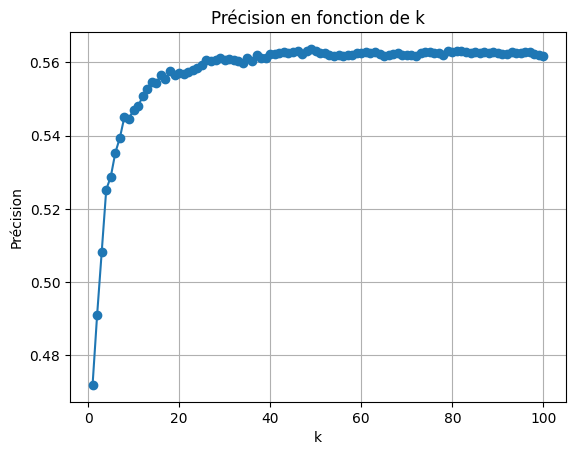

In [48]:
# tracage du graphique
k_values = range(1, 101)
plt.plot(k_values, mean_accuracy_list, marker='o')
plt.xlabel('k')
plt.ylabel('Précision')
plt.title('Précision en fonction de k')
plt.grid(True)
plt.show()

##### 2.2.3 - Distance Minkowski

In [16]:
# Initialisation de p pour avoir la distance minkowski
p = 2

# Liste pour stocker les valeurs d'accuracy
accuracy_list = []

# Boucle faisant varier k de 1 à 100
for k in range(1, 101):
    # Liste pour stocker les valeurs d'accuracy pour chaque k
    k_accuracy_list = []
    
    # Boucle faisant la prédiction et l'évaluation pour chaque répartition holdout
    for i in range(5):
        # Accès aux bases provenant de la répartition holdout
        X_app, X_test, y_app, y_test = holdout_app_test_sets[i]

        # Création du modèle KNN
        knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=p)

        # Apprentissage du modèle KNN
        knn.fit(X_app, y_app)

        # Prédiction des données de test
        y_pred = knn.predict(X_test)

        # Evaluation de la prédiction
        accuracy = accuracy_score(y_test, y_pred)

        # Ajout de l'accuracy à la liste pour chaque k
        k_accuracy_list.append(accuracy)
    
    # Ajout de la liste des accuracy pour chaque k à la liste principale
    accuracy_list.append(k_accuracy_list)

# Calcul de la moyenne des accuracy pour chaque k
mean_accuracy_list = [np.mean(acc) for acc in accuracy_list]

# Affichage des moyennes des accuracy pour chaque k
for k, mean_acc in enumerate(mean_accuracy_list):
    print("Moyenne de l'accuracy pour k =", k+1, ":", mean_acc)

# Récupération de l'indice correspondant à la moyenne de l'accuracy la plus grande dans la liste
n = np.argmax(mean_accuracy_list)

print("Indice de la moyenne de l'accuracy la plus grande :", n+1)

Moyenne de l'accuracy pour k = 1 : 0.46840653511563757
Moyenne de l'accuracy pour k = 2 : 0.48839380437088903
Moyenne de l'accuracy pour k = 3 : 0.5059834500318269
Moyenne de l'accuracy pour k = 4 : 0.5222151495862508
Moyenne de l'accuracy pour k = 5 : 0.5251007850625928
Moyenne de l'accuracy pour k = 6 : 0.5328665393592191
Moyenne de l'accuracy pour k = 7 : 0.5353065987693613
Moyenne de l'accuracy pour k = 8 : 0.5399957564184171
Moyenne de l'accuracy pour k = 9 : 0.540441332484617
Moyenne de l'accuracy pour k = 10 : 0.5427328665393591
Moyenne de l'accuracy pour k = 11 : 0.5454063229365584
Moyenne de l'accuracy pour k = 12 : 0.5467218332272438
Moyenne de l'accuracy pour k = 13 : 0.549395289624443
Moyenne de l'accuracy pour k = 14 : 0.5497559940589858
Moyenne de l'accuracy pour k = 15 : 0.550753235730957
Moyenne de l'accuracy pour k = 16 : 0.5505834924676426
Moyenne de l'accuracy pour k = 17 : 0.551283683428814
Moyenne de l'accuracy pour k = 18 : 0.5523445788245279
Moyenne de l'accuracy

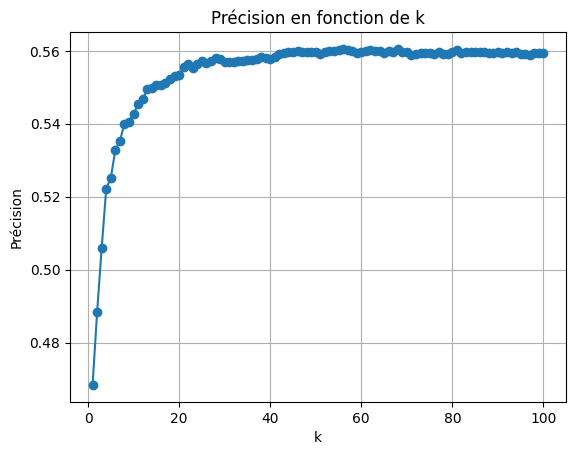

In [45]:
# tracage du graphique
k_values = range(1, 101)
plt.plot(k_values, mean_accuracy_list, marker='o')
plt.xlabel('k')
plt.ylabel('Précision')
plt.title('Précision en fonction de k')
plt.grid(True)
plt.show()

### 3 - Classification avec trois algorithmes de « haut niveau »

#### 3.1 - Classification avec SVM

In [17]:
def SVM_class(X,Y,old_model=None):
    #création d'un classifieur SVM
    svm = SVC()
    svm_params = {'kernel':('sigmoid', 'rbf'), 'C':[0.1, 1, 10, 100]}
    
    #aram_grid = {
    #    'C': [0.1, 1, 10, 100, 500, 1000, 2000, 5000, 10000], 
    #    'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    #}
    
    svm_grid = GridSearchCV(svm, svm_params, cv=3, n_jobs=4)
    svm_grid.fit(X, Y)
    best_svm = svm_grid.best_estimator_

    #enregistrement du modèle avec les meilleurs paramètres
    #comparaison avec l'ancien modèle pour ne pas le remplacer si moins performant
    if old_model == None:
        joblib.dump(best_svm, 'models/svm_model.pkl')
    else:
        if old_model.score(X,Y) < best_svm.score(X,Y):
            joblib.dump(best_svm, 'models/svm_model.pkl')
    # retourne le meilleur modèle
    return best_svm

In [26]:
for i in range(5):
        # Accès aux bases provenant de la répartition holdout
        X_app, X_test, y_app, y_test = holdout_app_test_sets[i]

        # Création du modèle KNN
        knn = KNeighborsClassifier(n_neighbors=68, metric='minkowski', p=p)

        # Apprentissage du modèle KNN
        knn.fit(X_app, y_app)

        # Prédiction des données de test
        y_pred = knn.predict(X_test)

        # Evaluation de la prédiction
        accuracy = accuracy_score(y_test, y_pred)

        # Ajout de l'accuracy à la liste pour chaque k
        k_accuracy_list.append(accuracy)
        
        print("Accuracy pour i =", i, ":", accuracy)

Accuracy pour i = 0 : 0.5653511563759813
Accuracy pour i = 1 : 0.560471037555697
Accuracy pour i = 2 : 0.5565457245915553
Accuracy pour i = 3 : 0.5573944409081265
Accuracy pour i = 4 : 0.5628050074262678


In [32]:
#calcul de la moyenne des accuracy
accuracy_values = [0.5653511563759813, 0.560471037555697, 0.5565457245915553, 0.5573944409081265, 0.5628050074262678]
mean_accuracy = sum(accuracy_values) / len(accuracy_values)
print("Moyenne de l'accuracy :", mean_accuracy)

Moyenne de l'accuracy : 0.5605134733715256


In [33]:
# Accès à la répartition provenants de la répartition holdout
X_app, X_test, y_app, y_test = holdout_app_test_sets[0]

# Récupération d'échantillons du dataset
X_app_sample = X_app.sample(frac=0.025, random_state=42)
X_test_sample = X_test.sample(frac=0.025, random_state=42)
y_app_sample = y_app.sample(frac=0.025, random_state=42)
y_test_sample = y_test.sample(frac=0.025, random_state=42)

In [34]:
# Initialisation du modèle 
best_svm = None

# Selection du meilleur modèle SVM
best_svm = SVM_class(X_app, y_app, best_svm)

#### 3.2 - Classification avec Random Forest

In [28]:
def RF_class(X,Y,old_model=None):
    #création d'un classifieur Random Forest
    rf = RandomForestClassifier()
    #rf_params = {'n_estimators': [10, 100], 'max_depth': [None, 10]}
    rf_params = {'n_estimators':[10, 100, 1000], 'max_depth':[None, 10, 100]}
    rf_grid = GridSearchCV(rf, rf_params, cv=5)
    #rf_grid = GridSearchCV(rf, rf_params, cv=3)
    rf_grid.fit(X, Y)
    best_rf = rf_grid.best_estimator_

    #enregistrement du modèle avec les meilleurs paramètres
    #comparaison avec l'ancien modèle pour ne pas le remplacer si moins performant
    if old_model == None:
        joblib.dump(best_rf, 'models/rf_model.pkl')
    else:
        if old_model.score(X,Y) < best_rf.score(X,Y):
            joblib.dump(best_rf, 'models/rf_model.pkl')


    return best_rf

In [29]:
# Initialisation du modèle 
best_rf = None

# Selection du meilleur modèle SVM
best_rf = RF_class(X_app, y_app, best_rf)

#### 3.3 - Classification avec MLP

In [30]:
def MLP_class(X,Y,old_model=None):
    #création d'un classifieur MLP
    mlp = MLPClassifier()
    #mlp_params = {'hidden_layer_sizes':[(10,), (100,), (1000,)], 'activation':['relu', 'tanh', 'logistic']}
    mlp_params = {'hidden_layer_sizes': [(10,), (100,)], 'activation': ['relu', 'tanh']}
    mlp_grid = GridSearchCV(mlp, mlp_params, cv=5)
    mlp_grid.fit(X, Y)
    best_mlp = mlp_grid.best_estimator_

    #enregistrement du modèle avec les meilleurs paramètres
    #comparaison avec l'ancien modèle pour ne pas le remplacer si moins performant
    if old_model == None:
        joblib.dump(best_mlp, 'models/mlp_model.pkl')
    else:
        if old_model.score(X,Y) < best_mlp.score(X,Y):
            joblib.dump(best_mlp, 'models/mlp_model.pkl')

    return best_mlp

In [31]:
# Initialisation du modèle 
best_mlp = None

# Selection du meilleur modèle SVM
best_mlp = MLP_class(X_app, y_app, best_mlp)

#### 3.4 - Fusion classifieurs

In [51]:
#vote majoritaire
voting_clf_maj = VotingClassifier(estimators=[('svm', best_svm), ('rf', best_rf), ('mlp', best_mlp)], voting='hard')
voting_clf_maj.fit(X, Y)

#prediction sur un nouveau jeu de données (à modifier avec les jeux de données de test)
X_pred = X_test

#prediction vote majoritaire
Y_pred_maj = voting_clf_maj.predict(X_test)

### 4 - Évaluation quantitative des résultats « supervisé »

#### 4.1 - Taux d’apprentissage

In [52]:
from sklearn.model_selection import cross_val_score

##### 4.1.1 - SVM

In [53]:
# Calcul du taux de classificatipn par validation croisée
res_svm = cross_val_score(best_svm, X_app, y_app, cv = 3, scoring = "accuracy")

print(res.mean())

KeyboardInterrupt: 

##### 4.1.2 - Random Forest

In [64]:
# Calcul du taux de classificatipn par validation croisée
res_rf = cross_val_score(best_rf, X_app, y_app, cv = 3, scoring = "accuracy")

print(res.mean())

0.5568846669189255


##### 4.1.3 - MLP

In [55]:
# Calcul du taux de classificatipn par validation croisée
res = cross_val_score(best_mlp, X_app, y_app, cv = 3, scoring = "accuracy")

print(res.mean())

c:\Users\micka\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.5568846669189255


#### 4.2 - Matrice de confusion
 

##### 4.2.1 - SVM

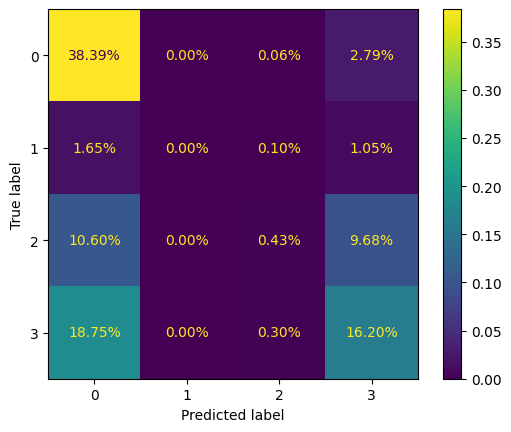

In [70]:
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# best_svm = None
# best_svm = MLP_class(X_app, y_app, best_svm)

y_pred = best_svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='.2%')
plt.show()

##### 4.2.2 - Random Forest

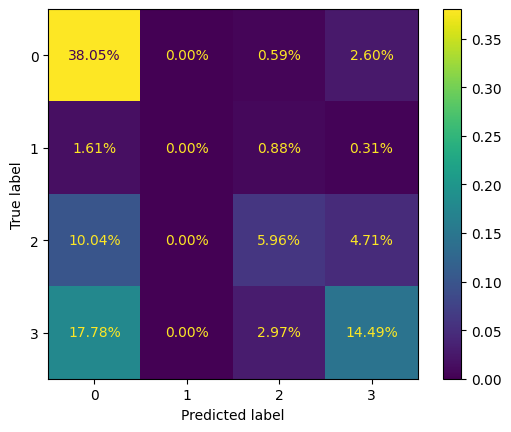

In [69]:
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# best_rf = None
# best_rf = MLP_class(X_app, y_app, best_rf)

y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='.2%')
plt.show()

##### 4.2.3 - MLP

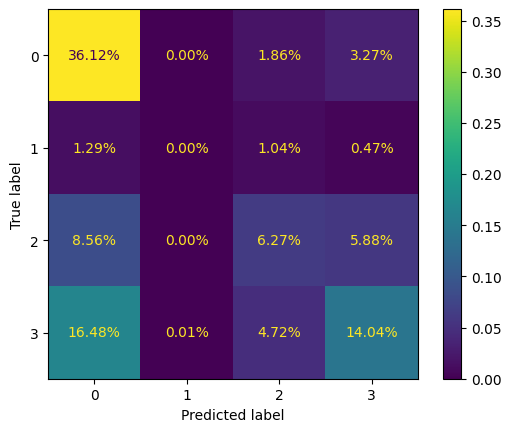

In [68]:
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# best_mlp = None
# best_mlp = MLP_class(X_app, y_app, best_mlp)

y_pred = best_mlp.predict(X_test)
cm = confusion_matrix(y_test, y_pred, normalize="all")

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='.2%')
plt.show()

#### 4.3 - Précision/Rappel

In [72]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict

##### 4.3.1 - SVM

In [73]:
# Génération des prédictions par validation croisée
pred_svm = cross_val_predict(best_svm, X_app, y_app, cv=3)

print(precision_score(y_app, pred_svm, average='micro'))
print(recall_score(y_app, pred_svm, average='micro'))
print(f1_score(y_app, pred_svm, average='micro'))

0.545164288889787
0.545164288889787
0.545164288889787


##### 4.3.2 - Random Forest

In [74]:
# Génération des prédictions par validation croisée
pred_rf = cross_val_predict(best_rf, X_app, y_app, cv=3)

print(precision_score(y_app, pred_rf, average='micro'))
print(recall_score(y_app, pred_rf, average='micro'))
print(f1_score(y_app, pred_rf, average='micro'))

0.577496665723639
0.577496665723639
0.577496665723639


##### 4.3.3 - MLP

In [75]:
# Génération des prédictions par validation croisée
pred_mlp = cross_val_predict(best_mlp, X_app, y_app, cv=3)

print(precision_score(y_app, pred_mlp, average='micro'))
print(recall_score(y_app, pred_mlp, average='micro'))
print(f1_score(y_app, pred_mlp, average='micro'))

0.5555510649476619
0.5555510649476619
0.5555510649476619
